In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.columns = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 
              'atemp', 'humidity', 'windspeed', 'casual', 'registered','count']
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
""" 
— datetime – date and time of the statement
— season – 1 = winter, 2 = spring, 3 = summer, 4 = autumn
— holiday – indicates if the day is a school holiday
– workingday – indicates if the day is working (not weekend or holiday)
— weather – 1: Clear to cloudy, 2: Fog, 3: Light rain or snow, 4: Heavy showers or snow
— temp – temperature in degrees Celsius
— atemp – felt temperature in degrees Celsius
— humidity – humidity level
— windspeed – wind speed
— casual – number of rentals of non-subscribed users
— registered – number of subscribed user rentals
— count — total number of bike rentals 
"""

' \n— datetime – date and time of the statement\n— season – 1 = winter, 2 = spring, 3 = summer, 4 = autumn\n— holiday – indicates if the day is a school holiday\n– workingday – indicates if the day is working (not weekend or holiday)\n— weather – 1: Clear to cloudy, 2: Fog, 3: Light rain or snow, 4: Heavy showers or snow\n— temp – temperature in degrees Celsius\n— atemp – felt temperature in degrees Celsius\n— humidity – humidity level\n— windspeed – wind speed\n— casual – number of rentals of non-subscribed users\n— registered – number of subscribed user rentals\n— count — total number of bike rentals \n'

<AxesSubplot:>

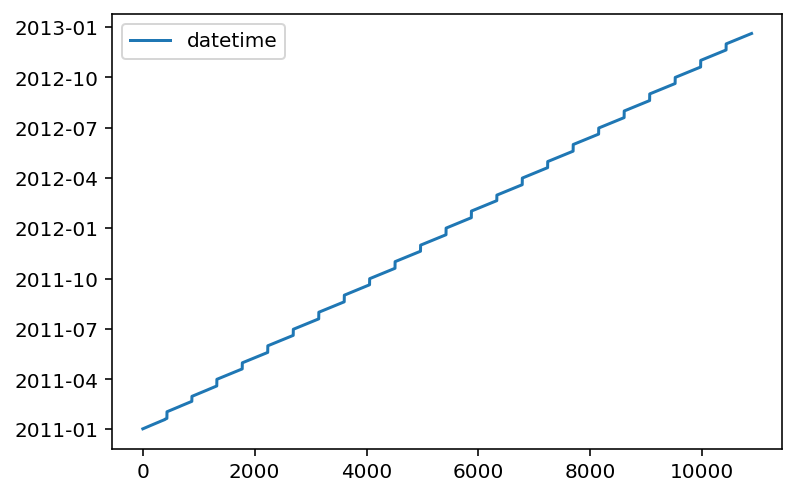

In [4]:
df.plot(y='datetime')

In [5]:
# Create hour, day and month as new features

dates = df.datetime
hours = [date.hour for date in dates]
days = [date.weekday() for date in dates]
months = [date.month for date in dates]

df['day'] = days
df['month'] = months
df['hour'] = hours

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,5,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,5,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,5,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2,12,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2,12,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2,12,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2,12,22


<AxesSubplot:xlabel='datetime'>

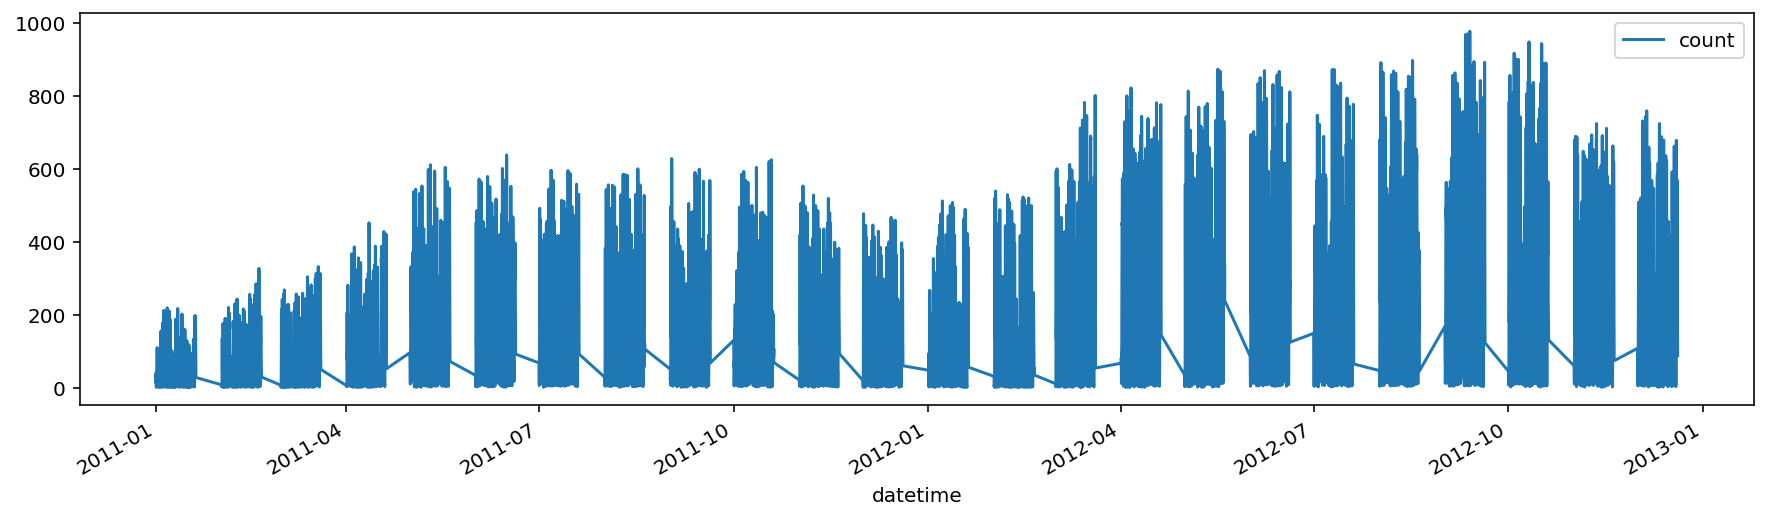

In [6]:
df.plot(x='datetime', y='count', figsize=(15,4))

### Analysis of bike rents and correlation with weather conditions

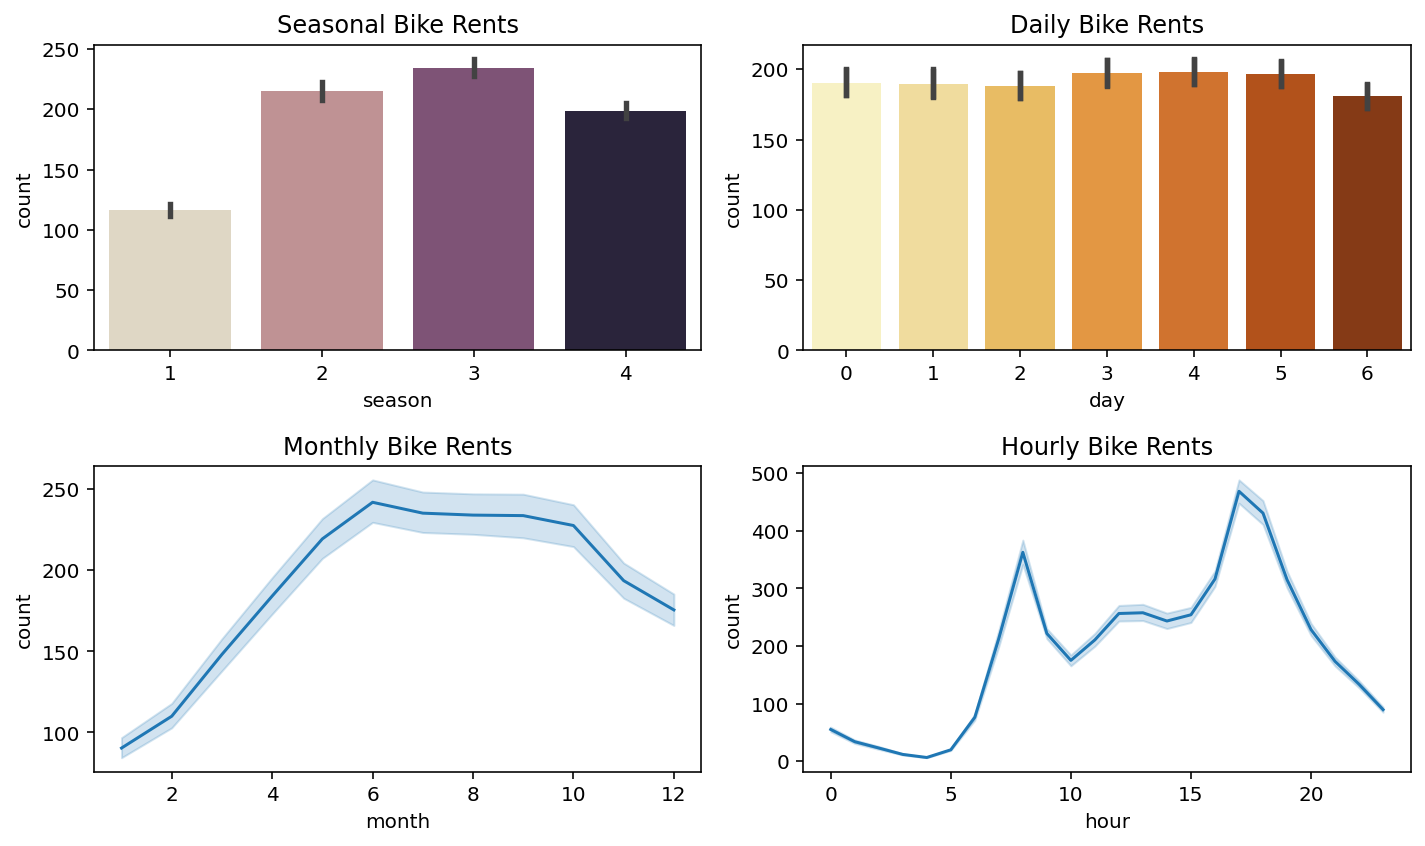

In [7]:
x = [['season', 'day'], ['month', 'hour']]
title = [['Seasonal Bike Rents', 'Daily Bike Rents'], 
         ['Monthly Bike Rents', 'Hourly Bike Rents']]

f, ax = plt.subplots(2,2,figsize=(10,6))

for i in range(2):
    for j in range(2):
        if i==0:
            sns.barplot(data=df, x=x[i][j], y='count', ax=ax[i][j], palette='ch:s=-.2,r=.6')
            if j==1:
                sns.barplot(data=df, x=x[i][j], y='count', ax=ax[i][j], palette='YlOrBr')

        else:
            sns.lineplot(data=df, x=x[i][j], y='count', ax=ax[i][j])

        ax[i][j].set_title(title[i][j])

plt.tight_layout()

##### The highest number of bike rents occur in summer (3) while the least bike rents occur in winter (1). From day to day basis, the trend of bike rents is almost similar with slight peaking demands on Friday while drops on Sunday. In monthly basis, there are two peaks occur in June and October. In hourly basis, there are two peak occurences at 8am and at 6pm, which is most likely to be caused by workers going to office in the morning and going back home in the afternoon.

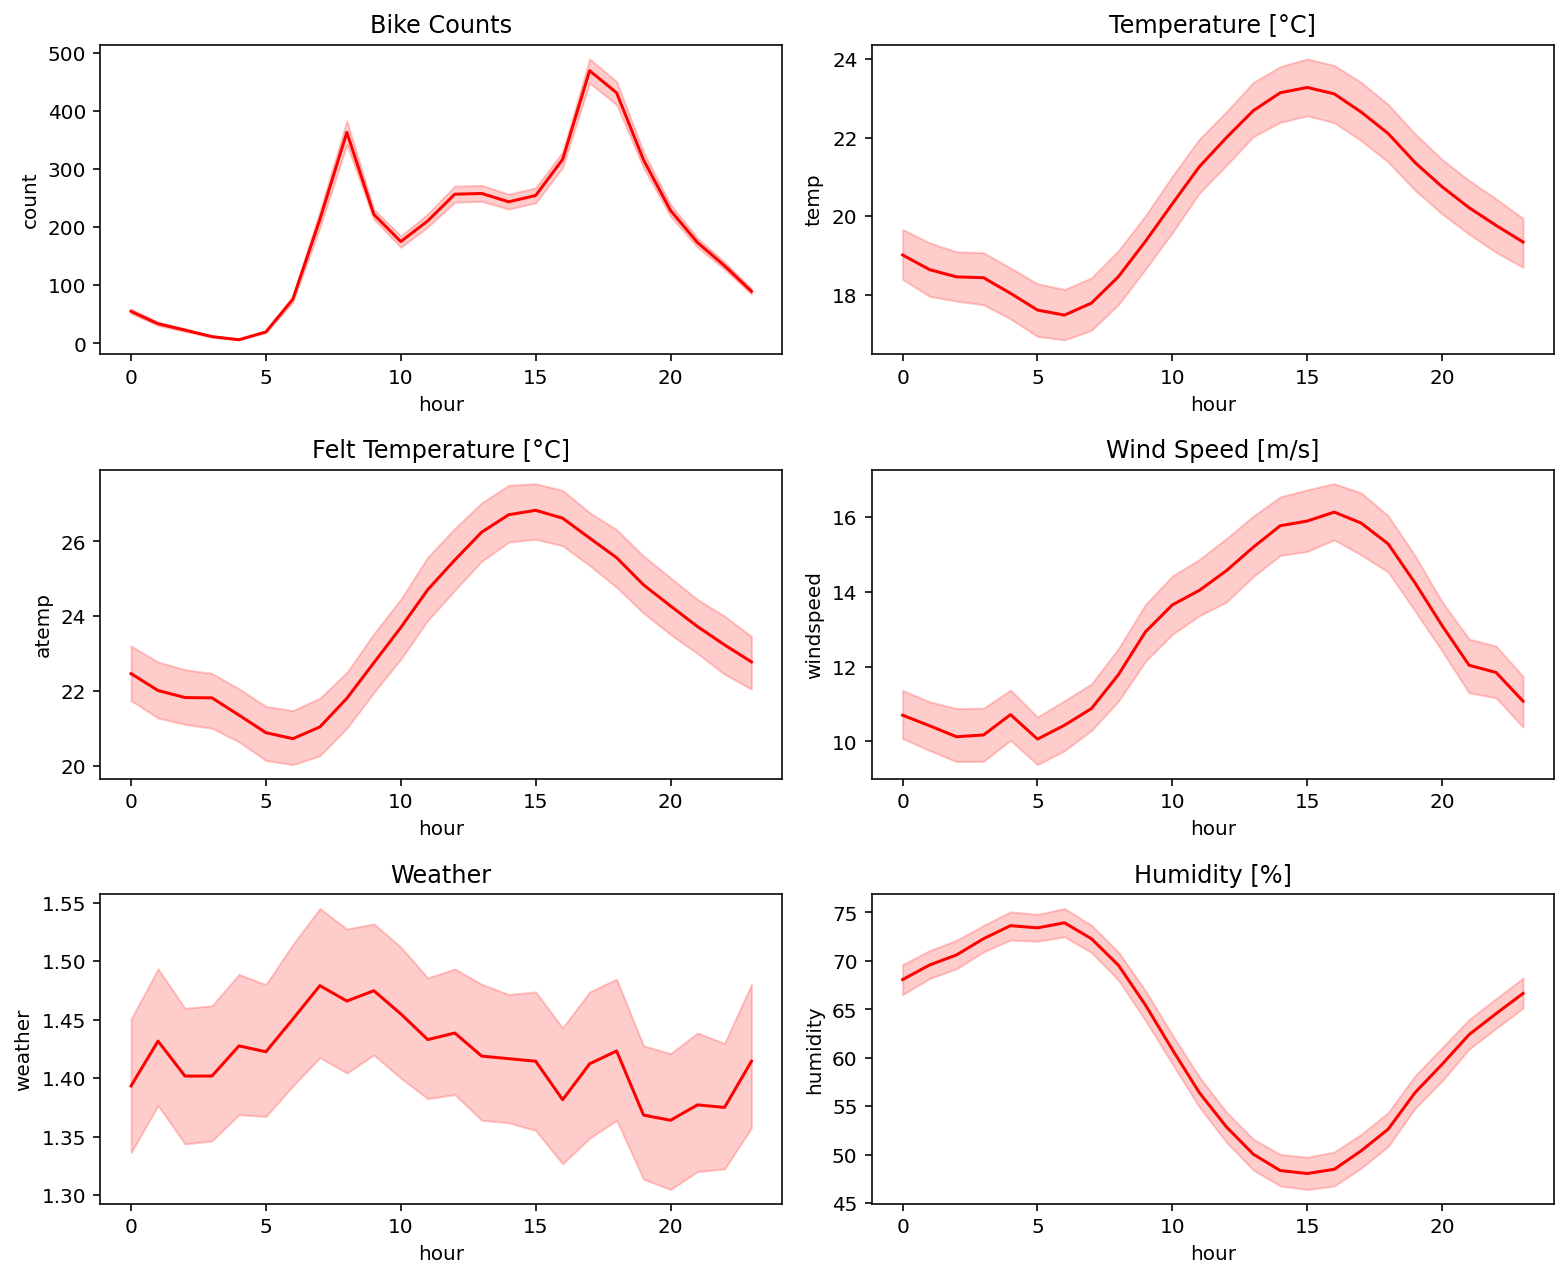

In [8]:
y = [['count', 'temp'], ['atemp', 'windspeed'], ['weather', 'humidity']]
title = [['Bike Counts', 'Temperature [°C]'], ['Felt Temperature [°C]', 'Wind Speed [m/s]'], 
         ['Weather', 'Humidity [%]']]

f, ax = plt.subplots(3,2,figsize=(11,9))

for i in range(3):
    for j in range(2):
        sns.lineplot(data=df, x='hour', y=y[i][j], ax=ax[i][j], color='r')
        ax[i][j].set_title(title[i][j])

plt.tight_layout()

#### The hourly movement of bike counts seems to correlate with temperature, felt temperature, windspeed and humidity. The bike counts peak in the afternoon (from 15.00 to 20.00) where temperature is the highest, with the most windspeed and least humidity.

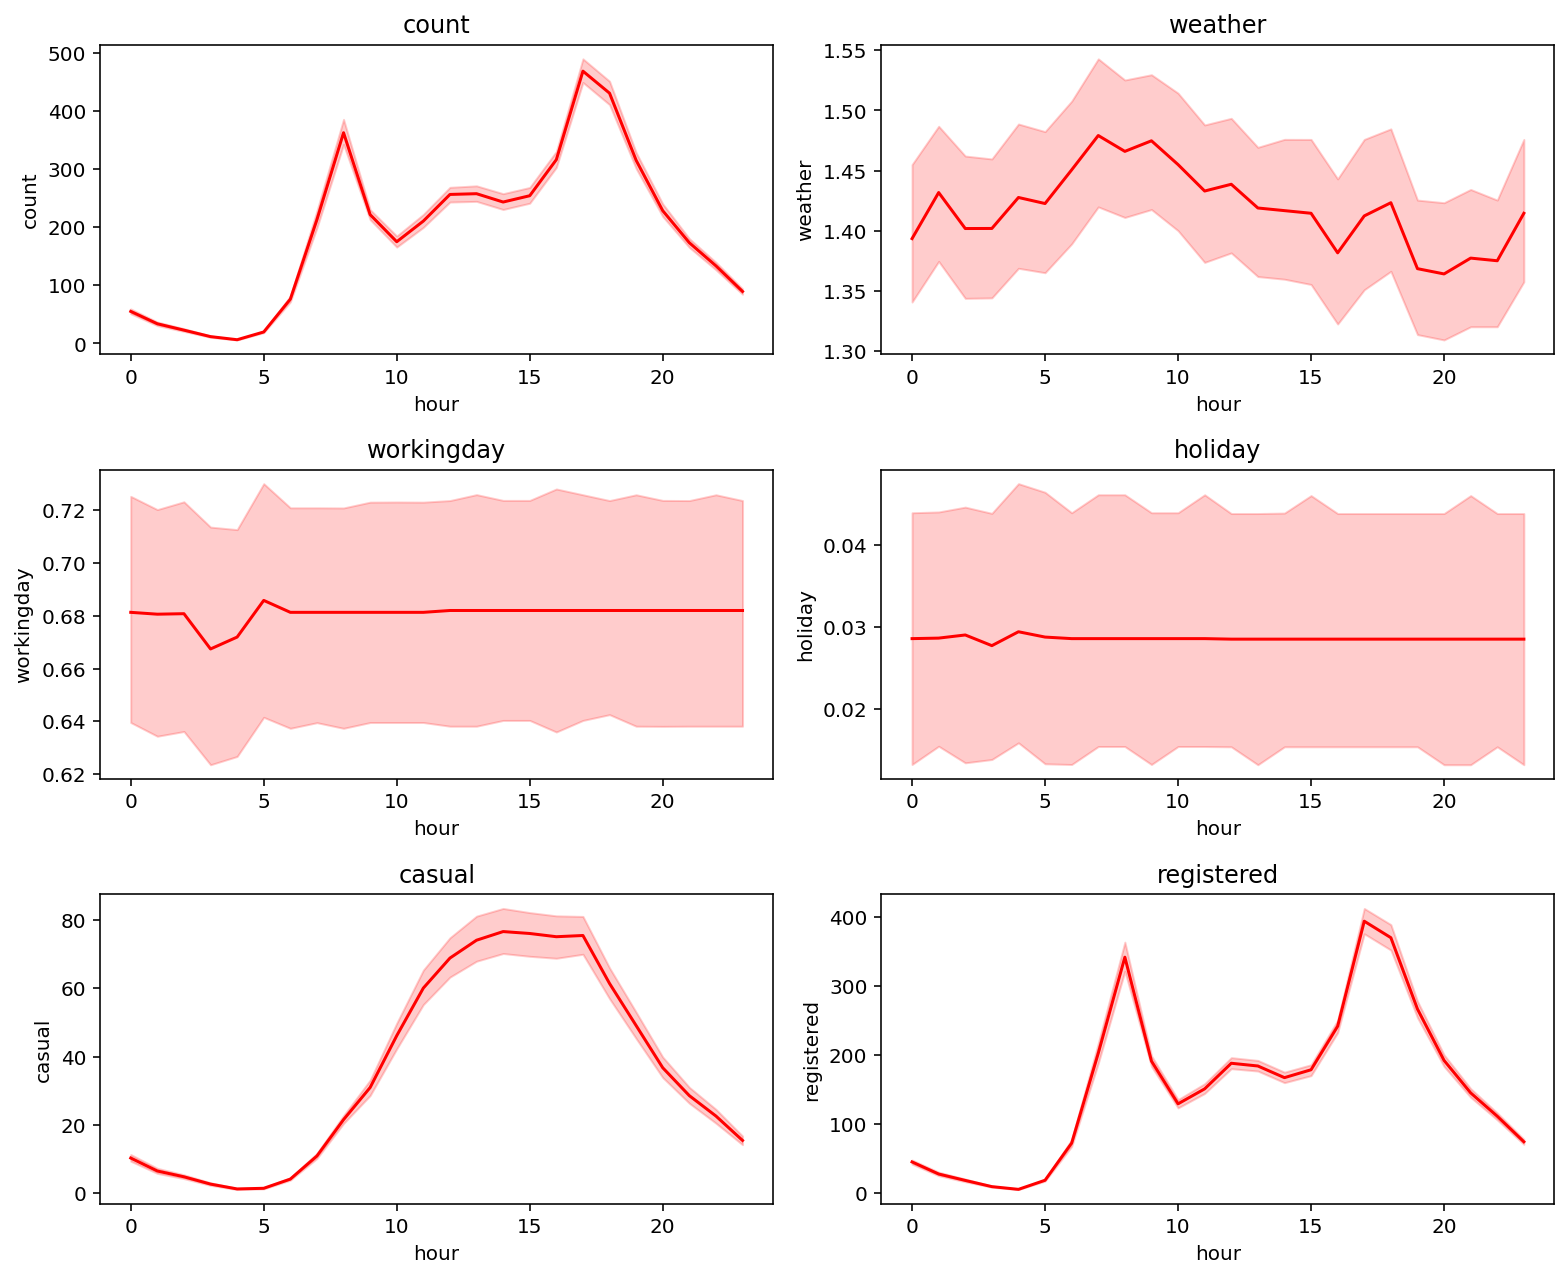

In [9]:
y = [['count', 'weather'], ['workingday', 'holiday'], ['casual', 'registered']]
title = [['count', 'weather'], ['workingday', 'holiday'], ['casual', 'registered']]

f, ax = plt.subplots(3,2,figsize=(11,9))

for i in range(3):
    for j in range(2):
        sns.lineplot(data=df, x='hour', y=y[i][j], ax=ax[i][j], color='r')
        ax[i][j].set_title(title[i][j])

plt.tight_layout()

#### Amog above features, the hourly movement of bike counts seems to correlate only with registered bikes.

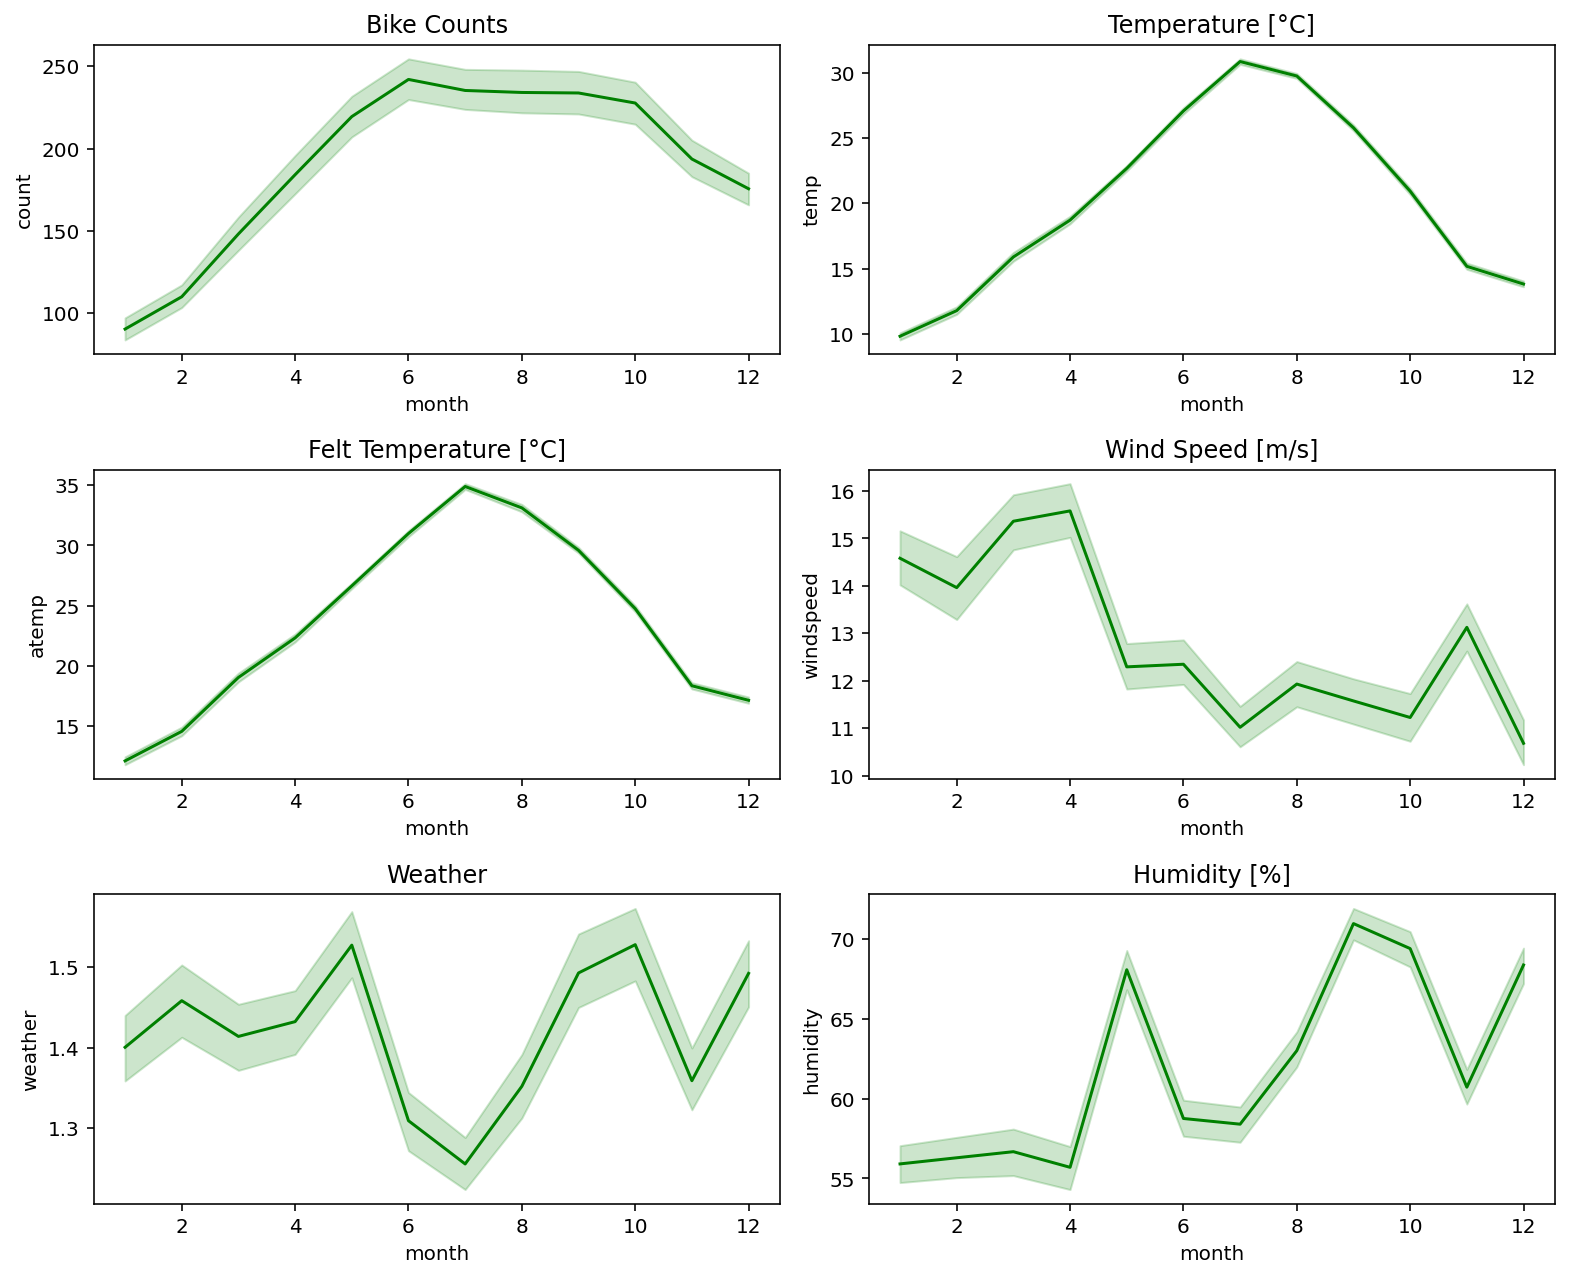

In [10]:
y = [['count', 'temp'], ['atemp', 'windspeed'], ['weather', 'humidity']]
title = [['Bike Counts', 'Temperature [°C]'], ['Felt Temperature [°C]', 'Wind Speed [m/s]'], 
         ['Weather', 'Humidity [%]']]

f, ax = plt.subplots(3,2,figsize=(11,9))

for i in range(3):
    for j in range(2):
        sns.lineplot(data=df, x='month', y=y[i][j], ax=ax[i][j], color='green')
        ax[i][j].set_title(title[i][j])

plt.tight_layout()  

#### The monthly movement of bike counts seems only to correlate with temperature. The highest rent was during summer time.

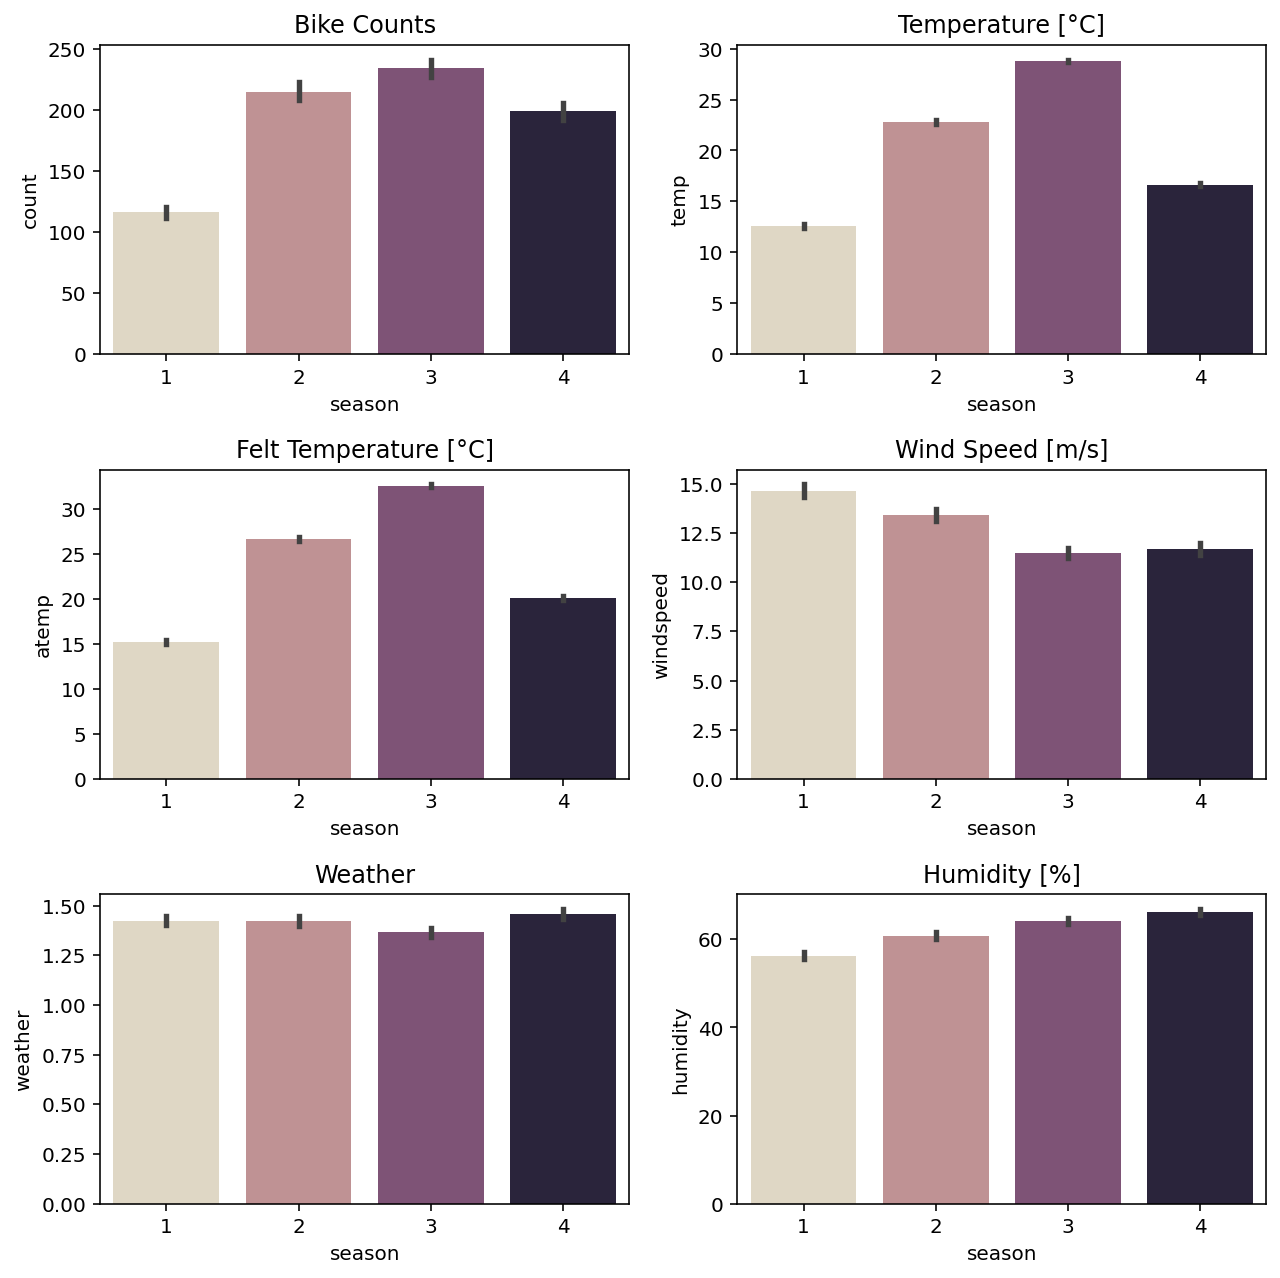

In [11]:
y = [['count', 'temp'], ['atemp', 'windspeed'], ['weather', 'humidity']]
title = [['Bike Counts', 'Temperature [°C]'], ['Felt Temperature [°C]', 'Wind Speed [m/s]'], 
         ['Weather', 'Humidity [%]']]

f, ax = plt.subplots(3,2,figsize=(9,9))

for i in range(3):
    for j in range(2):
        sns.barplot(data=df, x='season', y=y[i][j], ax=ax[i][j], palette='ch:s=-.2,r=.6')
        ax[i][j].set_title(title[i][j])

plt.tight_layout() 

#### The seasonal movement of bike counts correlates very well with temperature and felt temperature. The highest count of rented bikes occurs in summer, while the least occurs in winter.

In [12]:
dates = df[(df.holiday==1) & (df.workingday==0)].datetime.dt.date.unique()  ## On public holidays it keeps operating
dates

array([datetime.date(2011, 1, 17), datetime.date(2011, 4, 15),
       datetime.date(2011, 7, 4), datetime.date(2011, 9, 5),
       datetime.date(2011, 10, 10), datetime.date(2011, 11, 11),
       datetime.date(2012, 1, 2), datetime.date(2012, 1, 16),
       datetime.date(2012, 4, 16), datetime.date(2012, 7, 4),
       datetime.date(2012, 9, 3), datetime.date(2012, 10, 8),
       datetime.date(2012, 11, 12)], dtype=object)

C:\Users\Hripsime\AppData\Local\Temp\ipykernel_14720\2335105748.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


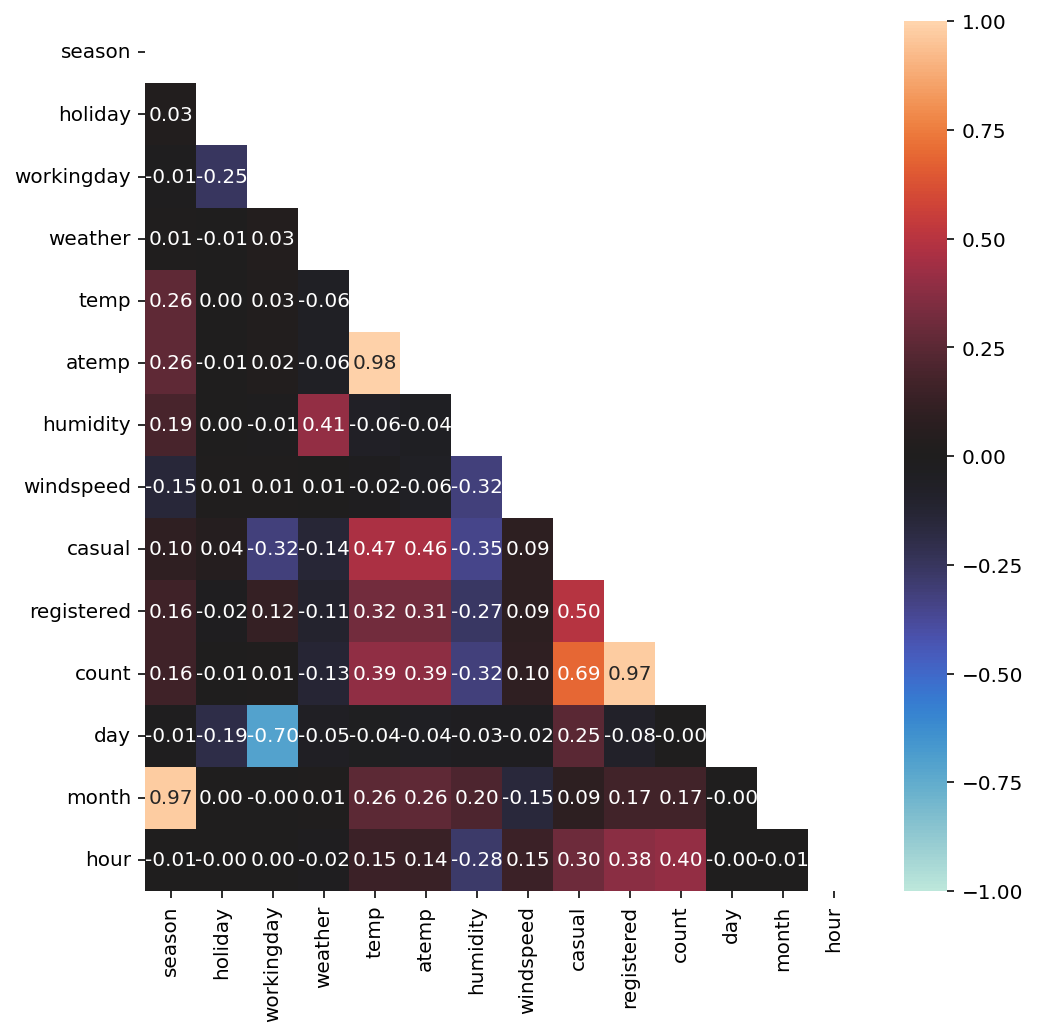

In [13]:
def corr_heatmap(df):    
    plt.figure(figsize=(8,8))

    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='icefire')    
corr_heatmap(df)    

In [14]:
# Feature and target
X = df.drop(columns=['count', 'datetime'], axis=1)
y = df['count']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost model
model = XGBRegressor()

# Cross-validation
cv = cross_val_score(model, X_train, y_train, cv=10)
print('10-fold R2 scores:', cv)
print('Mean R2', np.mean(cv))


10-fold R2 scores: [0.99956662 0.99939908 0.99950201 0.99931532 0.99944857 0.99956427
 0.99946579 0.99957078 0.99931473 0.9992277 ]
Mean R2 0.9994374873622329


In [15]:
# Achieve 99.94% R2-score of the XGBoost model 

(0.0, 3500.0)

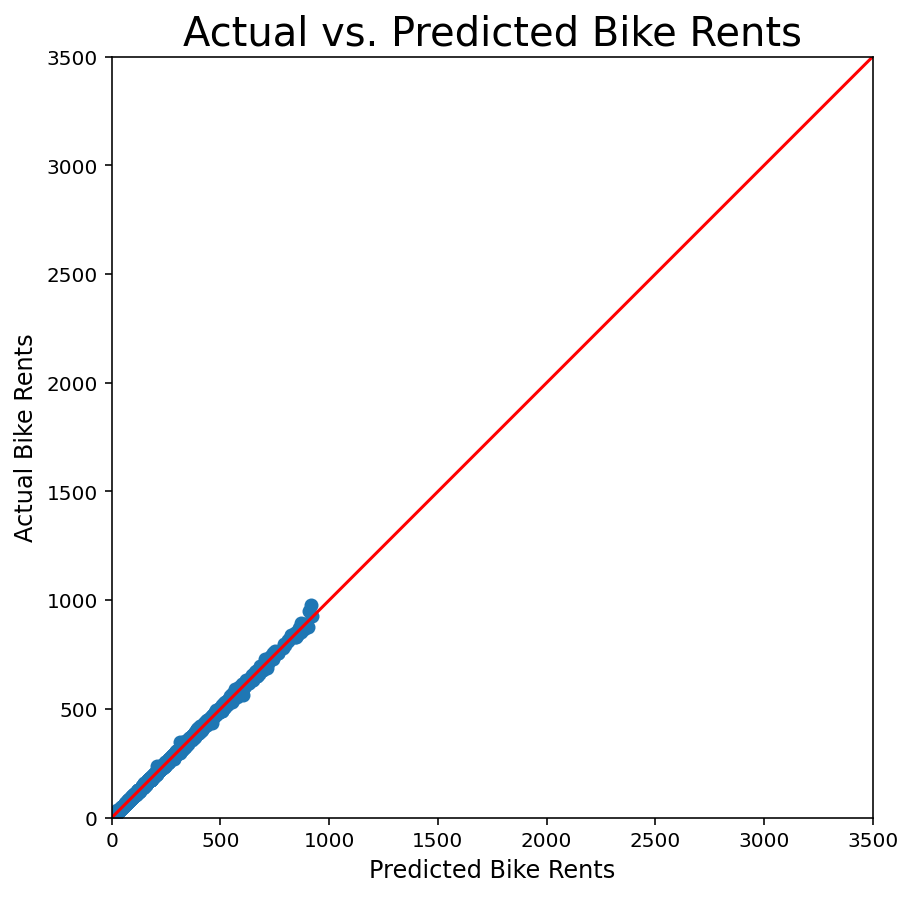

In [16]:
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(7,7))

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Bike Rents', size=12)
plt.ylabel('Actual Bike Rents', size=12)
plt.title('Actual vs. Predicted Bike Rents', size=20)
plt.xlim(0,3500)
plt.ylim(0,3500)

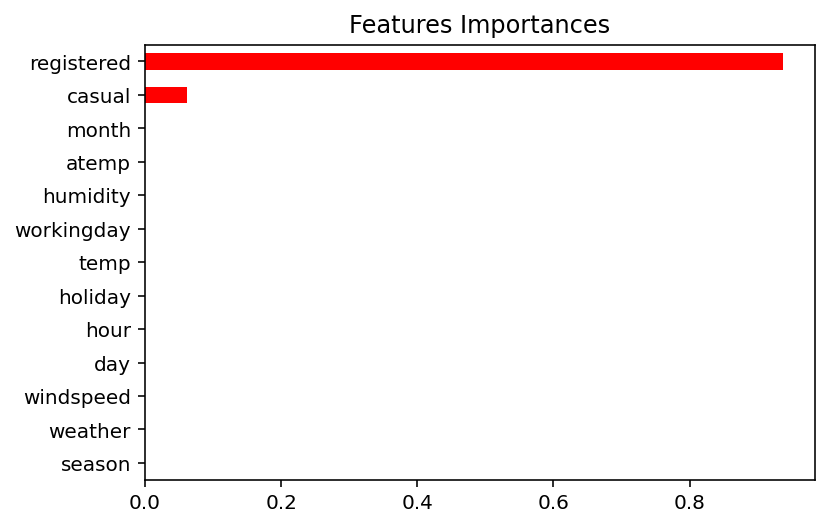

In [18]:
# Create a pd.Series of features importances
fimp = model.feature_importances_
importances = pd.Series(data=fimp,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importances')
plt.show()

#### The most important features are 'registered' and 'casual', we can remove them to see how it is affecting on prediction 

In [19]:
# Feature and target
X = df.drop(columns=['count', 'datetime', 'casual', 'registered'], axis=1)
y = df['count']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost model
model = XGBRegressor()

# Cross-validation
cv = cross_val_score(model, X_train, y_train, cv=10)
print('10-fold R2 scores:', cv)
print('Mean R2', np.mean(cv))


10-fold R2 scores: [0.87481312 0.87750373 0.87408583 0.86808672 0.89284062 0.88019928
 0.87260305 0.88457085 0.86823193 0.87989255]
Mean R2 0.8772827682167662


In [20]:
# After dropping 2 most important features R2-score of the XGBoost model decreased 12.2% decrease (from 99.94% to 87.74%)

(0.0, 3500.0)

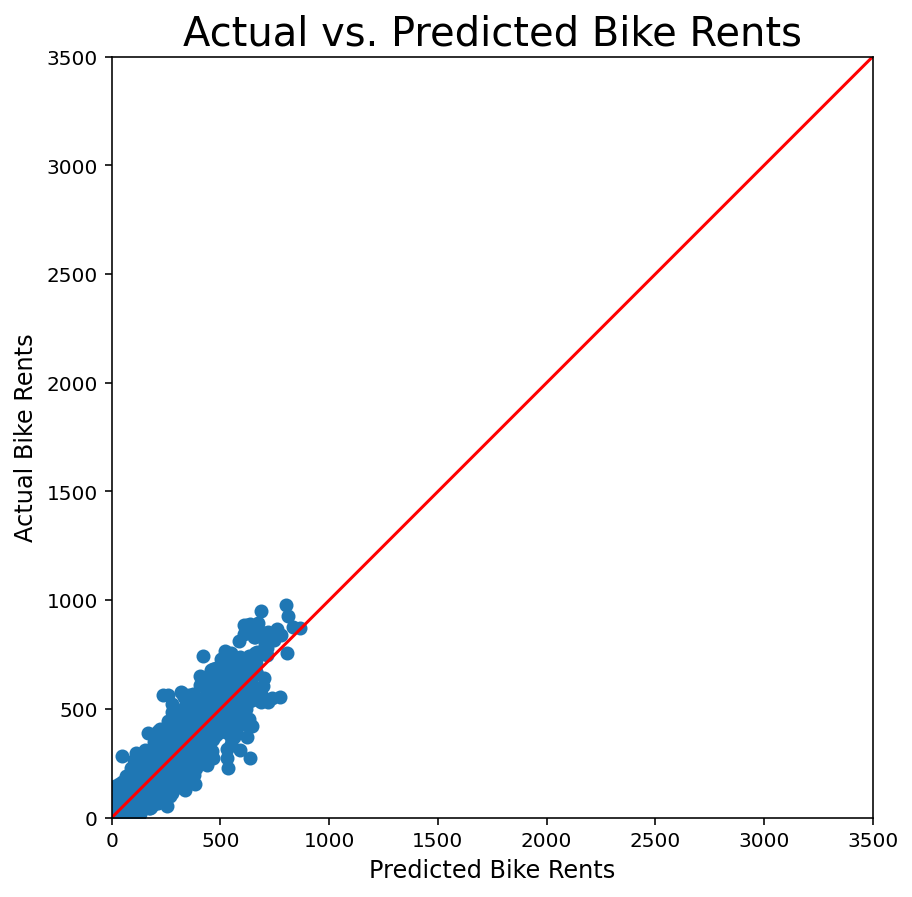

In [21]:
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(7,7))

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Bike Rents', size=12)
plt.ylabel('Actual Bike Rents', size=12)
plt.title('Actual vs. Predicted Bike Rents', size=20)
plt.xlim(0,3500)
plt.ylim(0,3500)

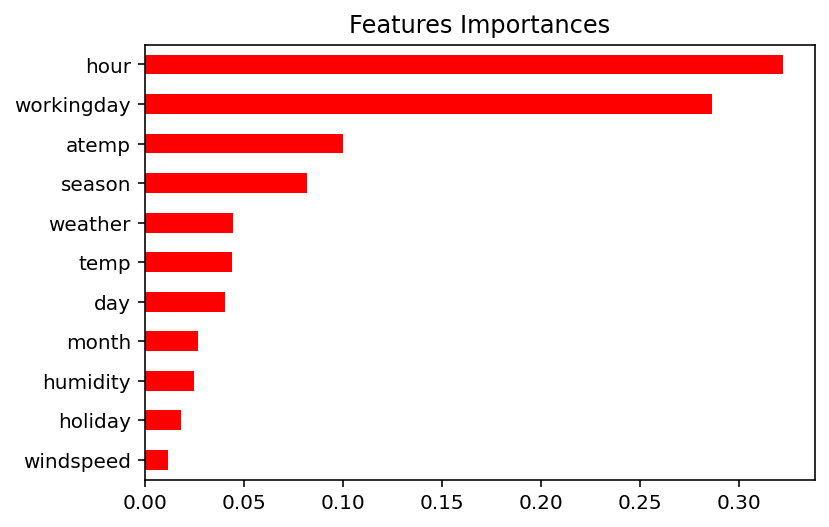

In [22]:
# Create a pd.Series of features importances
fimp = model.feature_importances_
importances = pd.Series(data=fimp,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importances')
plt.show()